## 2nd Cycle of Data Science Life Cycle
In this cycle I'll add some exogenous variables to the feature matrix such as weather forecast data.

### Imports

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import datetime as dt
import scipy as spy
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn import metrics 
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

%matplotlib inline
    
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

### Business Understanding
* Exogenous factors:
    * Generation data (biomass, fossil fuels, wind, solar)
    * Load data (forecast or actual)
    * Weather data (temp, wind_speed, rain, humidity, preassure, clouds, snow)
    * Other prices data (fuel price, other market price...) 
***    
Some references:
<br>
Article about feature engineering techniques for time series data <a href='https://www.analyticsvidhya.com/blog/2019/12/6-powerful-feature-engineering-techniques-time-series/' target="_blank">here</a>
<br>
Article about multivariate time series forecasting using random forests <a href="https://towardsdatascience.com/multivariate-time-series-forecasting-using-random-forest-2372f3ecbad1" target="_blank">here</a>. 
<br>
Kaggle notebook about electricity price forecasting with DNNs <a href="https://www.kaggle.com/dimitriosroussis/electricity-price-forecasting-with-dnns-eda" target="_blank">here</a>.
<br>
Kaggle notebook about time Series - Exploratory Data Analysis & Forecast <a href="https://www.kaggle.com/rgrajan/time-series-exploratory-data-analysis-forecast" target="_blank">here</a>.
<br>
Article about 'Statistical Modeling of Time Series Data Part 2: Exploratory Data Analysis' <a href="https://towardsai.net/p/data-visualization/statistical-modeling-of-time-series-data-part-2-exploratory-data-analysis" target="_blank">here</a>.
<br>
Article about 'How-To Guide on Exploratory Data Analysis for Time Series Data' <a href="https://medium.com/analytics-vidhya/how-to-guide-on-exploratory-data-analysis-for-time-series-data-34250ff1d04f" target="_blank">here</a>

### Data Collection

In [2]:
#Upload main dataset for hourly market prices from June 2020 to June 2021
data = pd.read_csv('Data/price_data.csv')

In [3]:
#Upload main dataset for weather forecast from June 2020 to June 2021
weather_data = pd.read_csv('Data/weather_data.csv')

In [4]:
site_dataframes = []
#Upload each site's dataset for weather forecast from June 2020 to June 2021
site_names = weather_data.site_name.unique()
for i in site_names:
    name= i + '_data'
    name = pd.read_csv('Data/' + i + '.csv')
    site_dataframes.append(name)

### Data Preparation

In [5]:
# Convert dates and times to datetime
data['date'] = pd.to_datetime(data.date, format="%Y-%m-%d")
data['start_time_uk'] = pd.to_datetime(data.start_time_uk, 
                                       format='%H:%M:%S').dt.time

In [6]:
# Convert to datetime all sites dataframes
for df in site_dataframes:
    df['date'] = pd.to_datetime(df.date, format="%Y-%m-%d")
    df['start_time_uk'] = pd.to_datetime(df.start_time_uk, 
                                           format='%H:%M:%S').dt.time
    df.sort_values(by='date')

# Choose the only site that has data for all days
rheidol_data = site_dataframes[0]

In [7]:
# Merge the market prices data with the rheidol_data dataframe since they have same time and dates
data= data.merge(rheidol_data).drop(labels='site_name', axis=1, inplace=False)

In [8]:
# Sort by date 
data.sort_values(by=['date'], ignore_index=True, 
                 inplace=True)

In [9]:
# Make 'date' the index
data.index = data['date'].rename('index')
data.index = pd.to_datetime(data.index)

In [10]:
#Checking for missing dates, if any found, return to 'Data Collection' to add it
pd.date_range(start = '2020-06-30', end = '2021-06-24' ).difference(data.index)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [11]:
# Create new columns with day of week ,year and month and weekday/weekend.
def add_day_week(dataframe):
    dataframe['weekday'] = dataframe['date'].apply(lambda x: x.weekday())
    
def add_month(dataframe):
    dataframe['month'] = dataframe['date'].apply(lambda x: x.month)
    
def add_year(dataframe):
    dataframe['year'] = dataframe['date'].apply(lambda x: x.year)
    
def add_day_week_name(dataframe):
    dataframe['weekday_name'] = dataframe['date'].apply(lambda x: x.strftime('%A'))

def add_month_name(dataframe):
    dataframe['month_name'] = dataframe['date'].apply(lambda x: x.strftime('%B'))
    
def weekday_weekend(dataframe):
    dataframe['weekday_or_weekend'] = dataframe['date'].apply(lambda x: 1 if x.strftime('%A') in ('Saturday','Sunday') else 0)

In [12]:
add_day_week(data)
add_month(data)
add_year(data)
add_day_week_name(data)
add_month_name(data)
weekday_weekend(data)

In [13]:
# Drop date column
data.drop(labels='date', axis=1, inplace=True)

In [14]:
data.info()
print("Dataframe shape: ", data.shape)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 360 entries, 2020-06-30 to 2021-06-24
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   value               360 non-null    float64
 1   start_time_uk       360 non-null    object 
 2   temperature         360 non-null    float64
 3   snow                360 non-null    float64
 4   ground_pressure     360 non-null    float64
 5   humidity            360 non-null    float64
 6   wind_speed          360 non-null    float64
 7   rain                360 non-null    float64
 8   pressure            360 non-null    float64
 9   wind_deg            360 non-null    float64
 10  clouds              360 non-null    float64
 11  weekday             360 non-null    int64  
 12  month               360 non-null    int64  
 13  year                360 non-null    int64  
 14  weekday_name        360 non-null    object 
 15  month_name          360 non-null    ob

In [15]:
# Print NaNs and duplicates in a dataframe
def NaN_duplicates(dataframe):
    print('There are {} missing values or NaNs in data.'
          .format(dataframe.isnull().values.sum()))

    duplicates_num = dataframe.duplicated(keep='first').sum()
    print('There are {} duplicate rows in data based on all columns.'
          .format(duplicates_num))

In [16]:
NaN_duplicates(data)

There are 0 missing values or NaNs in data.
There are 0 duplicate rows in data based on all columns.


In [17]:
# Build i day lag feature (revise after EDA)
def add_lag_feature(lag_num, column_to_lag, dataframe):
    """
    Adds one column to the data frame with some column's lagged values.
    Parameters:
    - lag_num: this is the number of lags we want, for example we can lag
        a column one day, two, three...
    - column_to_lag: this is the dataframe column we want to lag
    - dataframe: this is the dataframe to which we want to apply the lag function.
    """
    dataframe[str(lag_num) + '_day_lag'] = dataframe[column_to_lag].shift(lag_num).fillna(method='bfill')

In [18]:
for i in range(1,14):
    add_lag_feature(i,'value', data)

In [19]:
# Add standard moving average columns
def add_standard_moving_average(window, column_to_average, dataframe):
    """
    Adds one column to the data frame with some column's standard moving average.
    Parameters:
    - window: this is the number of rows we average over.
    - column_to_lag: this is the dataframe column we want to apply moving average to.
    - dataframe: this is the dataframe to which we want to apply the function.
    """
    dataframe[str(window) + '_std_moving_average'] = dataframe[column_to_average].rolling(window, min_periods=1).mean()
    
# Add expanding moving average 
def add_expanding_moving_average(column_to_average, dataframe):
    """
    Adds one column to the data frame with some column's expanding average.
    Parameters:
    - column_to_lag: this is the dataframe column we want to apply moving average to.
    - dataframe: this is the dataframe to which we want to apply the function.
    """
    dataframe['ex_moving_average'] = dataframe[column_to_average].expanding().mean()

In [20]:
add_standard_moving_average(15,'1_day_lag',data)
add_standard_moving_average(7,'1_day_lag',data)
add_standard_moving_average(3,'1_day_lag',data)
add_standard_moving_average(2,'1_day_lag',data)
add_expanding_moving_average('value',data)

In [21]:
data.head(8)

,value,start_time_uk,temperature,snow,ground_pressure,humidity,wind_speed,rain,pressure,wind_deg,...,9_day_lag,10_day_lag,11_day_lag,12_day_lag,13_day_lag,15_std_moving_average,7_std_moving_average,3_std_moving_average,2_std_moving_average,ex_moving_average
index,,,,,,,,,,,,,,,,,,,,,
2020-06-30,34.12,10:00:00,12.13,0.0,989.556,89.1,5.175,0.125,1005.846,225.164,...,34.12,34.12,34.12,34.12,34.12,34.120000,34.120000,34.120000,34.120,34.120000
2020-07-01,34.70,10:00:00,12.55,0.0,986.473,96.9,4.440,0.250,1003.263,241.316,...,34.12,34.12,34.12,34.12,34.12,34.120000,34.120000,34.120000,34.120,34.410000
2020-07-02,35.00,10:00:00,13.66,0.0,992.977,90.9,2.152,0.312,1009.487,250.513,...,34.12,34.12,34.12,34.12,34.12,34.313333,34.313333,34.313333,34.410,34.606667
2020-07-03,33.67,10:00:00,12.74,0.0,996.285,93.4,8.794,1.438,1012.374,217.232,...,34.12,34.12,34.12,34.12,34.12,34.485000,34.485000,34.606667,34.850,34.372500
2020-07-04,37.94,10:00:00,14.15,0.0,992.069,97.9,9.004,0.125,1007.987,236.712,...,34.12,34.12,34.12,34.12,34.12,34.322000,34.322000,34.456667,34.335,35.086000
2020-07-05,-0.01,10:00:00,12.15,0.0,993.169,75.6,10.379,0.125,1009.604,256.079,...,34.12,34.12,34.12,34.12,34.12,34.925000,34.925000,35.536667,35.805,29.236667
2020-07-06,29.01,10:00:00,11.75,0.0,1003.143,87.6,8.820,0.438,1019.845,306.387,...,34.12,34.12,34.12,34.12,34.12,29.934286,29.934286,23.866667,18.965,29.204286
2020-07-07,31.22,10:00:00,12.11,0.0,1002.845,84.6,4.767,0.062,1019.594,231.089,...,34.12,34.12,34.12,34.12,34.12,29.818750,29.204286,22.313333,14.500,29.456250




### Exploratory Data Analysis

In [22]:
data.columns.unique()

Index(['value', 'start_time_uk', 'temperature', 'snow', 'ground_pressure',
       'humidity', 'wind_speed', 'rain', 'pressure', 'wind_deg', 'clouds',
       'weekday', 'month', 'year', 'weekday_name', 'month_name',
       'weekday_or_weekend', '1_day_lag', '2_day_lag', '3_day_lag',
       '4_day_lag', '5_day_lag', '6_day_lag', '7_day_lag', '8_day_lag',
       '9_day_lag', '10_day_lag', '11_day_lag', '12_day_lag', '13_day_lag',
       '15_std_moving_average', '7_std_moving_average', '3_std_moving_average',
       '2_std_moving_average', 'ex_moving_average'],
      dtype='object')

<AxesSubplot:title={'center':'Market price evolution'}, xlabel='Date', ylabel='Price(£/MWh)'>

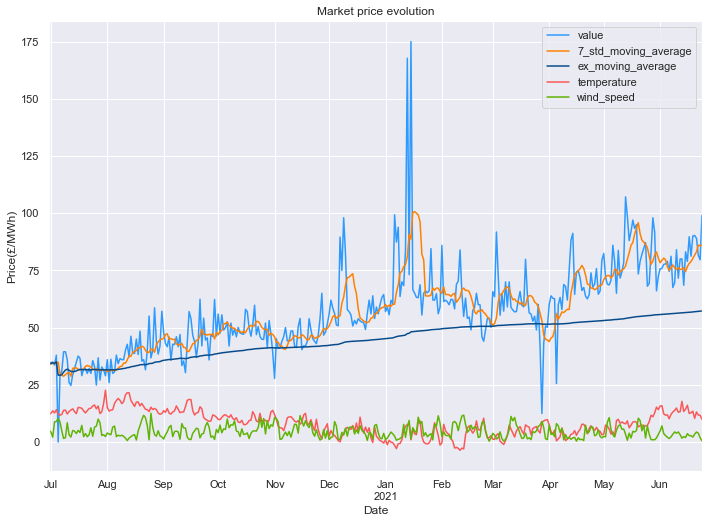

In [23]:
# Basic plot of time series and moving average.
data[['value','7_std_moving_average','ex_moving_average', 'temperature', 'wind_speed']].plot(
    ylabel='Price(£/MWh)', xlabel='Date', color=['#2E9AFE', '#FF8000','#084B8A', '#FA5858', '#5FB404'], title='Market price evolution')

/Users/monseguedesayala/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/monseguedesayala/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/monseguedesayala/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/monseguedesayala/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/monseguedesayala/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/monseguedesayala/opt/an

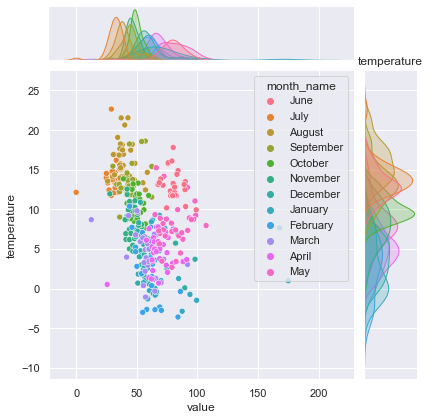

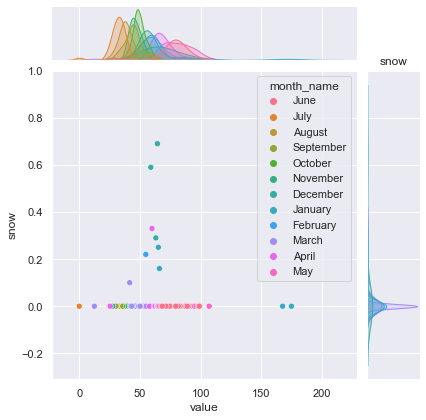

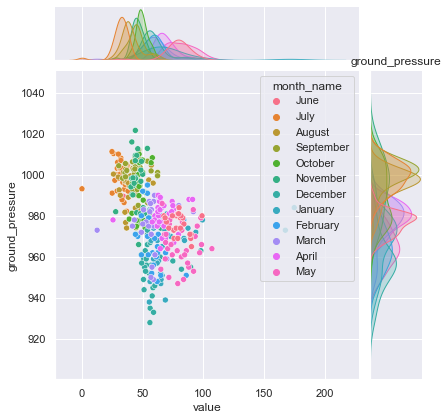

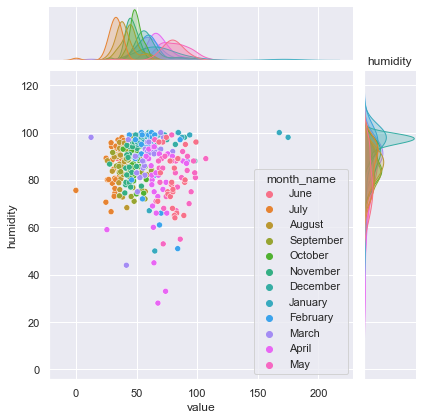

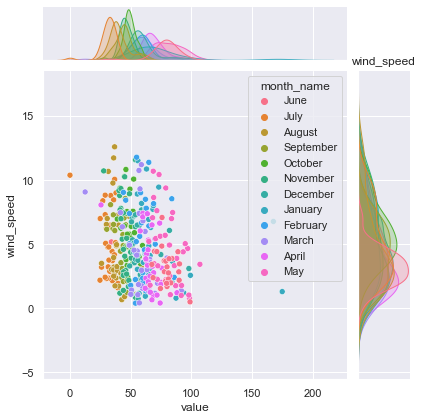

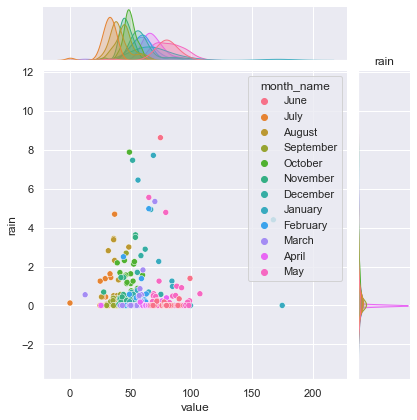

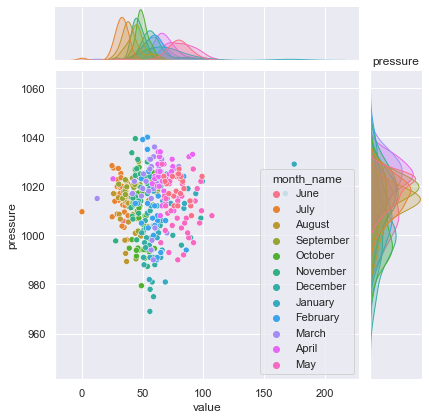

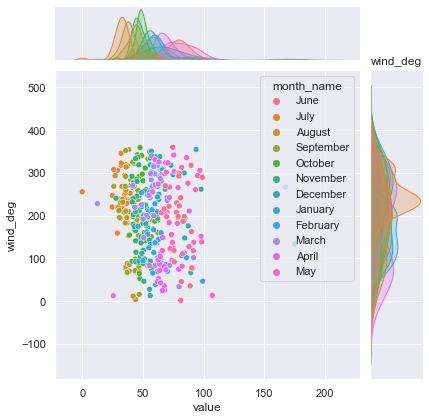

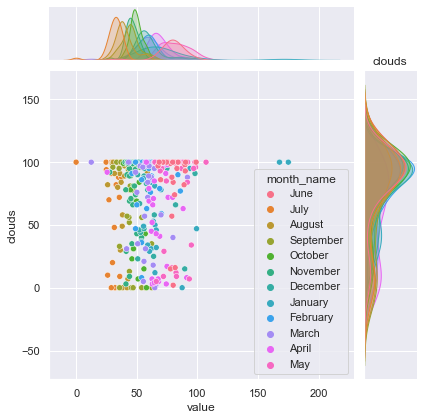

In [24]:
param_list = ['temperature', 'snow', 'ground_pressure',
       'humidity', 'wind_speed', 'rain', 'pressure', 'wind_deg',
       'clouds']
for parameter in param_list:
    sns.jointplot(data=data[['value', parameter, 'month_name']], x="value", 
                  y=parameter, hue="month_name")
    plt.title(parameter)

In [25]:
# Find correlation between features and price
correlations = data.corr(method='pearson')
print(correlations['value'].sort_values(ascending=False).to_string())

value                    1.000000
2_std_moving_average     0.785488
7_std_moving_average     0.778473
3_std_moving_average     0.773525
15_std_moving_average    0.753963
2_day_lag                0.737897
ex_moving_average        0.728102
1_day_lag                0.718286
7_day_lag                0.657840
year                     0.643790
5_day_lag                0.643352
3_day_lag                0.640728
6_day_lag                0.627235
4_day_lag                0.618285
8_day_lag                0.604600
9_day_lag                0.596019
13_day_lag               0.579868
11_day_lag               0.577927
10_day_lag               0.572215
12_day_lag               0.556936
pressure                 0.039961
snow                     0.024974
rain                     0.010865
clouds                  -0.007275
humidity                -0.008419
weekday                 -0.054765
weekday_or_weekend      -0.103777
wind_deg                -0.113535
wind_speed              -0.261849
month         

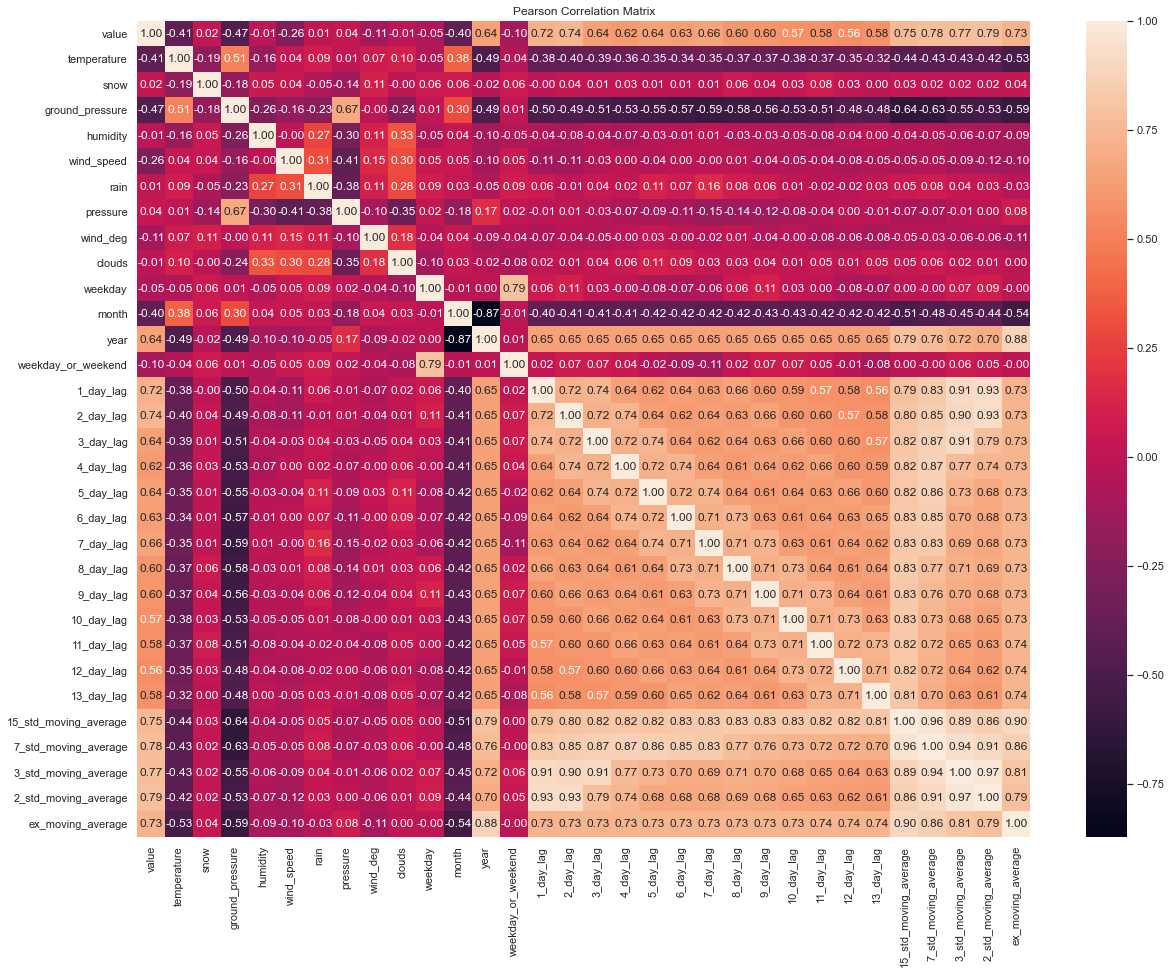

In [26]:
# Plot Pearson correlation matrix
correlations = data.corr(method='pearson')
plt.subplots(figsize=(20,15))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

<AxesSubplot:>

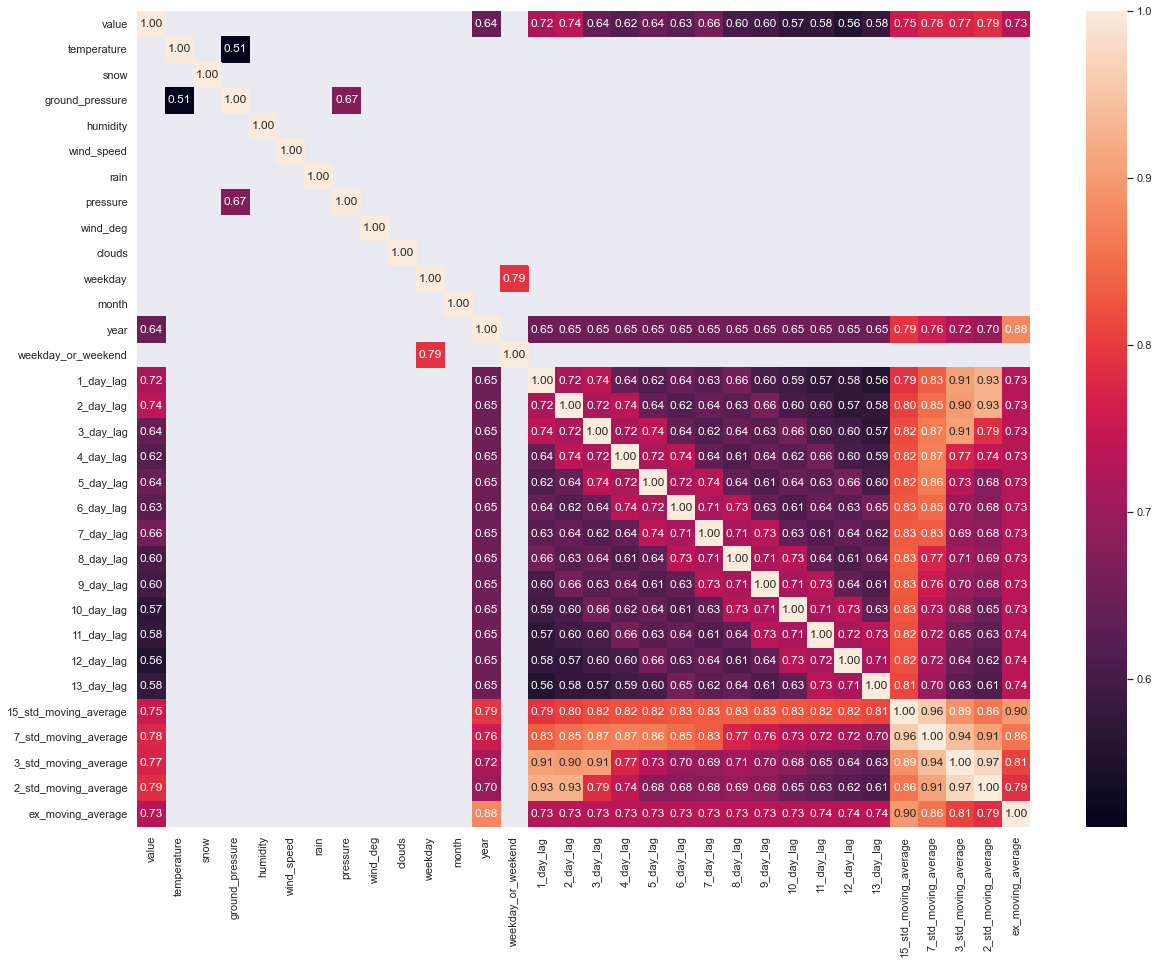

In [349]:
# Print features that are highly correlated to each other
highly_correlated = abs(correlations[correlations > 0.40])
#print(highly_correlated[highly_correlated < 1.0].stack().to_string())
plt.subplots(figsize=(20,15))
sns.heatmap(highly_correlated, annot=True, fmt='.2f')

In [350]:
# Stationarity check with ADF test
dftest = adfuller(data['value'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                  -2.115916
p-value                          0.238163
#Lags Used                       6.000000
Number of Observations Used    353.000000
Critical Value (1%)             -3.449011
Critical Value (5%)             -2.869763
Critical Value (10%)            -2.571151
dtype: float64


In [27]:
# Apply difference transform to make data stationary
data['diff_value'] = data['value'] - data['1_day_lag']

In [352]:
# Stationarity check with ADF test
dftest = adfuller(data['diff_value'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                -1.289513e+01
p-value                        4.364908e-24
#Lags Used                     5.000000e+00
Number of Observations Used    3.540000e+02
Critical Value (1%)           -3.448958e+00
Critical Value (5%)           -2.869739e+00
Critical Value (10%)          -2.571138e+00
dtype: float64


# Modelling

### Split dates into training and test data

In [28]:
# Split into training and test set
def divide_time_df(dataframe, proportion):
    num_dates = dataframe.shape[0]
    head = round(num_dates * proportion, 0)
    tail = num_dates - head 
    print('Total days are {}'.format(data.shape[0]))
    print('Head is {}'.format(head))
    print('Tail is {}'.format(tail))
    return head,tail

In [29]:
head, tail = divide_time_df(data, 0.8)
data_train = data.head(int(head))
data_test = data.tail(int(tail))
data_train.index = pd.DatetimeIndex(data_train.index.values,
                               freq=data_train.index.inferred_freq)

Total days are 360
Head is 288.0
Tail is 72.0


## Non-Stationary Models

## Random Forest model Non-Stationary

#### Convert data into training and test arrays for Random Forest

In [30]:
X_train = data_train.drop(['value','diff_value','start_time_uk','month_name','weekday_name','year'], axis=1).values
y_train = data_train.value.values

X_test = data_test.drop(['value','diff_value', 'start_time_uk','month_name','weekday_name','year'], axis=1).values
y_test = data_test.value.values

#### Grid search for best parameters (later improved to be tested in training)

In [31]:
# Array with all data
X = data.drop(['value','diff_value','start_time_uk',
               'month_name','weekday_name'], axis=1).values
y = data.value.values

In [32]:
def expanding_window(n, test_size, X, y, n_estimators, min_samples_split, 
                               min_samples_leaf, max_depth, plot):
    """
    This functions evaluates a model with a expanding window method.
    """
    total_size = X.shape[0]
    score = []
    initial_train = total_size - test_size*n
    for i in range(1,n+1):
        X_train = X[:initial_train]
        X_test = X[initial_train:initial_train + test_size]
        y_train = y[:initial_train]
        y_test = y[initial_train:initial_train + test_size]
        
        forest = RandomForestRegressor(n_estimators=n_estimators, min_samples_split= min_samples_split, 
                               min_samples_leaf=min_samples_leaf, max_depth=max_depth, random_state=0)
        forest.fit(X_train, y_train)
        y_hat = forest.predict(X_test)
        
        score.append(metrics.r2_score(y_test,y_hat))
        
        if plot == True:
            #plt.plot(range(y_test.shape[0]), y_test, label='Real values')
            #plt.plot(range(y_test.shape[0]), y_hat, label='RF prediction')
            #plt.legend()
            #plt.fill_between(range(y_test.shape[0]), y_test, y_hat, color='lightgrey')
            #plt.show()
            print('R2 are {}'.format(score))
        
        initial_train = initial_train + test_size
        
    #print('R2 are {}'.format(score))    
    return(np.mean(score))

In [160]:
print("Size of training set: {} size of test set: {}".format(
          X_train.shape[0], X_test.shape[0]))

RF_best_score = -11
for n_estimators in [10, 20, 50,100]: 
    for max_depth in [5,7,9,10,15,50]:
        for min_samples_split in [2,3,4]:
            for min_samples_leaf in [1,2,3,4]:
                # for each combination of parameters, train a model
                # evaluate the forest on the test set
                score = expanding_window(3, 20, X_train, y_train, n_estimators, 
                                         min_samples_split, min_samples_leaf, max_depth, False)
                # if we got a better score, store the score and parameters 
                if score > RF_best_score:
                    RF_best_score = score
                    RF_best_parameters = {'n_estimators': n_estimators, 'max_depth': max_depth,
                                         'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}
        
print("Best score: {:.2f}".format(RF_best_score)) 
print("Best parameters: {}".format(RF_best_parameters))

Size of training set: 288 size of test set: 72
Best score: -0.59
Best parameters: {'n_estimators': 20, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1}


#### Making and fitting Random Forest model with chosen parameters

In [33]:
forest = RandomForestRegressor(n_estimators=100, max_depth=9, min_samples_split=2, min_samples_leaf=2, random_state=0)
forest.fit(X_train, y_train)
y_hat = forest.predict(X_test)

#### Random Forest model Evaluation

In [34]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Accuracy on training set: 0.848
Accuracy on test set: -0.853
R2 is -0.8526121953724464
The mean absolute error is 11.297722980471583
The root mean squared error is 190.84322981780505
The mean absolute percentage error is 13.70832756138895


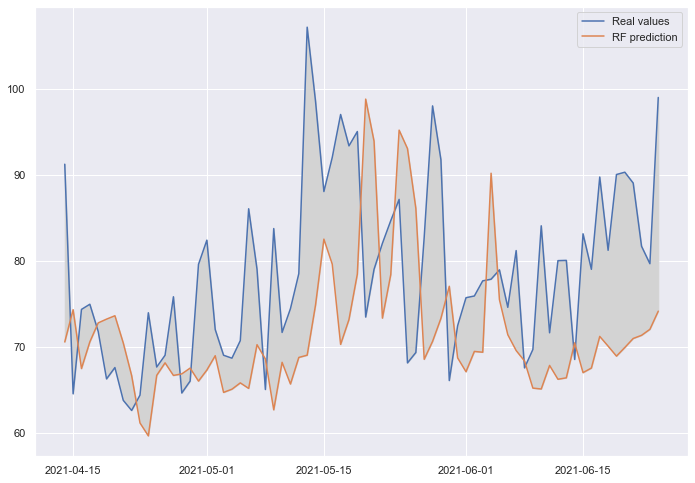

In [40]:
print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

# Scores:
# R^2
print('R2 is {}'
      .format(metrics.r2_score(y_test,y_hat)))
# MAE
print('The mean absolute error is {}'
      .format(metrics.mean_absolute_error(y_test,y_hat)))
# RMSE
print('The root mean squared error is {}'
      .format(metrics.mean_squared_error(y_test,y_hat)))
#MAPE
print('The mean absolute percentage error is {}'
      .format(mean_absolute_percentage_error(y_test,y_hat)))

#expanding_window(3, 20, X, y, n_estimators, min_samples_split, min_samples_leaf, max_depth, True)

plt.plot(data_test.index, y_test, label='Real values')
plt.plot(data_test.index, y_hat, label='RF prediction')
plt.legend()
plt.fill_between(data_test.index, y_test, y_hat, color='lightgrey')
plt.savefig('Plots/2rf_plot.png', bbox_inches='tight')

We can see that the model is again overfitting

We can see that it has some insight on where the peaks are, but it is shifted to the right.

In [41]:
features_names = data_train.drop(['value','diff_value','start_time_uk','month_name',
                           'weekday_name', 'year'], axis=1).columns

Feature temperature , Score: 0.05957
Feature snow , Score: 0.00005
Feature ground_pressure , Score: 0.00803
Feature humidity , Score: 0.01119
Feature wind_speed , Score: 0.02879
Feature rain , Score: 0.00488
Feature pressure , Score: 0.00349
Feature wind_deg , Score: 0.01165
Feature clouds , Score: 0.00309
Feature weekday , Score: 0.00923
Feature month , Score: 0.00239
Feature weekday_or_weekend , Score: 0.00045
Feature 1_day_lag , Score: 0.08517
Feature 2_day_lag , Score: 0.05025
Feature 3_day_lag , Score: 0.01365
Feature 4_day_lag , Score: 0.00645
Feature 5_day_lag , Score: 0.01713
Feature 6_day_lag , Score: 0.00887
Feature 7_day_lag , Score: 0.10312
Feature 8_day_lag , Score: 0.01999
Feature 9_day_lag , Score: 0.01386
Feature 10_day_lag , Score: 0.00901
Feature 11_day_lag , Score: 0.00699
Feature 12_day_lag , Score: 0.00301
Feature 13_day_lag , Score: 0.00709
Feature 15_std_moving_average , Score: 0.09307
Feature 7_std_moving_average , Score: 0.06007
Feature 3_std_moving_average , S

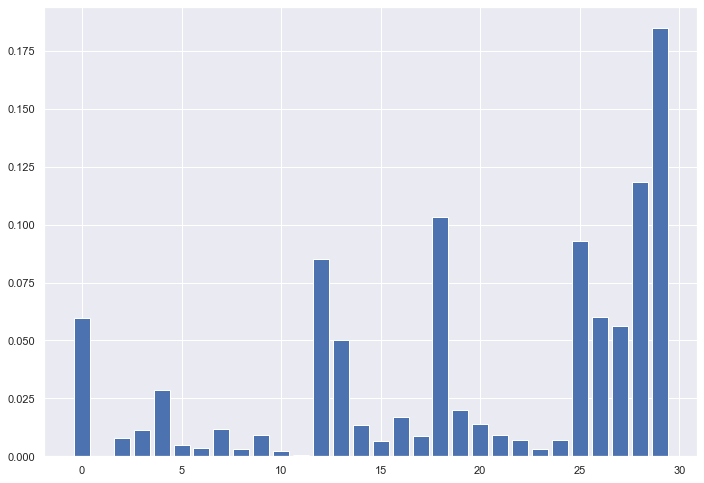

In [42]:
# Feature selection
importance = forest.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature ' + features_names[i] + ' , Score: %.5f' % (v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

#### Plotting predicted and real values with some features

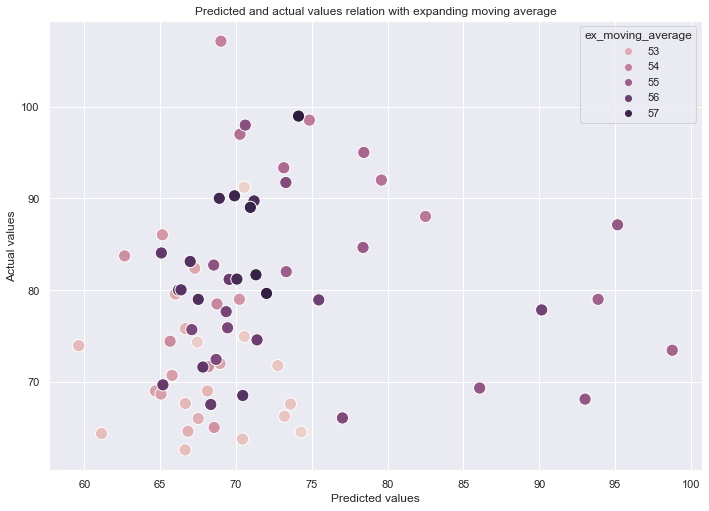

In [43]:
sns.scatterplot(x=y_hat, y=y_test, hue='ex_moving_average', data=data_test, s=150)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Predicted and actual values relation with expanding moving average')
plt.savefig('Plots/2rf_scatter.png', bbox_inches='tight')

<AxesSubplot:>

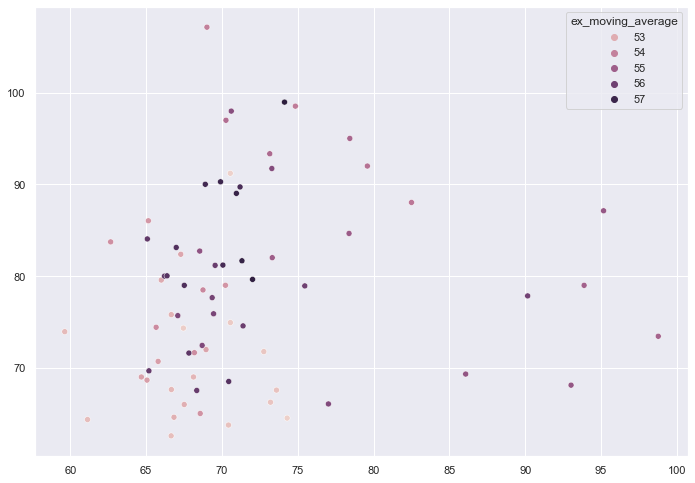

In [371]:
sns.scatterplot(x=y_hat, y=y_test, hue='ex_moving_average', data=data_test)

<AxesSubplot:>

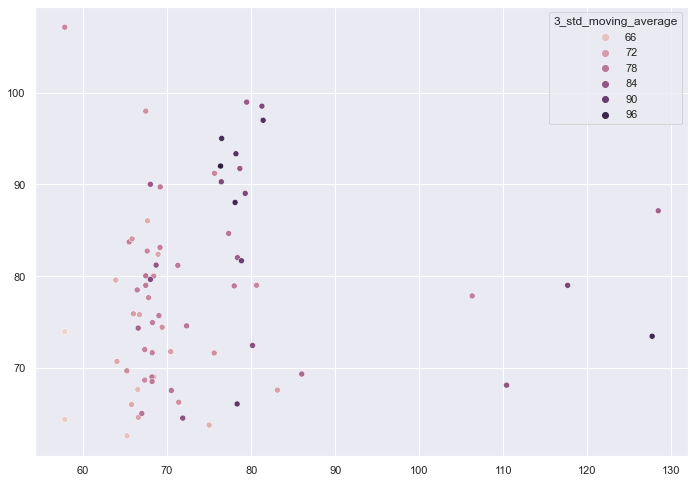

In [174]:
sns.scatterplot(x=y_hat, y=y_test, hue='3_std_moving_average', data=data_test)

### Creating the PCA Random Forest model Non-Stationary

Original shape: (360, 31)
Reduced shape: (360, 2)
X train shape: (288, 2)
X test shape: (72, 2)
y train shape: (288,)
y test shape: (72,)
Accuracy on training set: 0.812
Accuracy on test set: -1.604
R2 is -1.6037283513286242
The mean absolute error is 12.797060478673385
The root mean squared error is 268.2179947735076
The mean absolute percentage error is 15.822561311542735


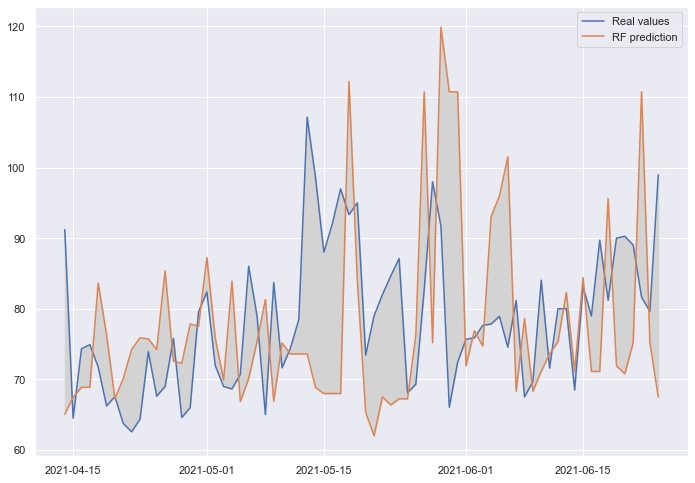

In [45]:
#We first scale the data
from sklearn.preprocessing import StandardScaler

X = data.drop(['value', 'diff_value','start_time_uk','month_name','weekday_name'], axis=1).values
y = data.value.values

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

#Reducing feature dimensionality with PCA
from sklearn.decomposition import PCA
#keep the first two principal components of the data 
pca = PCA(n_components=2)
pca.fit(X_scaled)
#transform data onto the first two principal components
X_pca = pca.transform(X_scaled)

print("Original shape: {}".format(str(X_scaled.shape))) 
print("Reduced shape: {}".format(str(X_pca.shape)))

X_train = X_pca[:int(head)]
X_test = X_pca[len(X_pca)-int(tail):len(X_pca)]
y_train = y[:int(head)]
y_test = y[len(X_pca)-int(tail):len(X_pca)]

print("X train shape: {}".format(X_train.shape)) 
print("X test shape: {}".format(X_test.shape))
print("y train shape: {}".format(y_train.shape)) 
print("y test shape: {}".format(y_test.shape))

forest = RandomForestRegressor(n_estimators=12, max_depth=7, random_state=0)
forest.fit(X_train, y_train)
y_hat = forest.predict(X_test)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

# Scores:
# R^2
print('R2 is {}'
      .format(metrics.r2_score(y_test,y_hat)))
# MAE
print('The mean absolute error is {}'
      .format(metrics.mean_absolute_error(y_test,y_hat)))
# RMSE
print('The root mean squared error is {}'
      .format(metrics.mean_squared_error(y_test,y_hat)))
#MAPE
print('The mean absolute percentage error is {}'
      .format(mean_absolute_percentage_error(y_test,y_hat)))

plt.plot(data_test.index, y_test, label='Real values')
plt.plot(data_test.index, y_hat, label='RF prediction')
plt.legend()
plt.fill_between(data_test.index, y_test, y_hat, color='lightgrey')
plt.savefig('Plots/2rf_pca_plot.png', bbox_inches='tight')

This model gives worse results than the one without the PCA

### Lasso model Non-Stationary

In [46]:
X_train = data_train.drop(['value','diff_value','start_time_uk','month_name','weekday_name','year'], axis=1).values
y_train = data_train.value.values

X_test = data_test.drop(['value','diff_value', 'start_time_uk','month_name','weekday_name','year'], axis=1).values
y_test = data_test.value.values

In [373]:
X_train = data_train.drop(['value','diff_value','start_time_uk','month_name','weekday_name'], axis=1).values
y_train = data_train.value.values

X_test = data_test.drop(['value','diff_value', 'start_time_uk','month_name','weekday_name'], axis=1).values
y_test = data_test.value.values

R2 is -0.9412603728911884
The mean absolute error is 11.789194745771075
The root mean squared error is 199.97514882243934
The mean absolute percentage error is 14.53033690796905
Accuracy on training set: 0.654
Accuracy on test set: -0.941


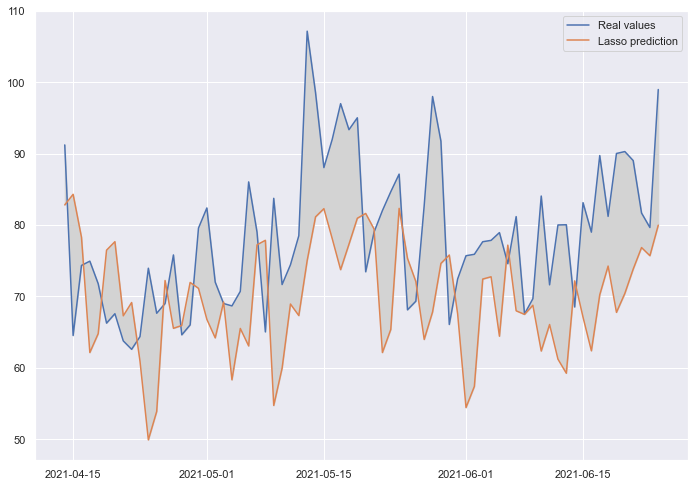

In [48]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.001, max_iter=5000000)
lasso.fit(X_train, y_train)
y_hat = lasso.predict(X_test)

# Scores:
# R^2
print('R2 is {}'
      .format(metrics.r2_score(y_test,y_hat)))
# MAE
print('The mean absolute error is {}'
      .format(metrics.mean_absolute_error(y_test,y_hat)))
# RMSE
print('The root mean squared error is {}'
      .format(metrics.mean_squared_error(y_test,y_hat)))
#MAPE
print('The mean absolute percentage error is {}'
      .format(mean_absolute_percentage_error(y_test,y_hat)))

print("Accuracy on training set: {:.3f}".format(lasso.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(lasso.score(X_test, y_test)))

plt.plot(data_test.index, y_test, label='Real values')
plt.plot(data_test.index, y_hat, label='Lasso prediction')
plt.legend()
plt.fill_between(data_test.index, y_test, y_hat, color='lightgrey')
plt.savefig('Plots/2rf_lasso_plot.png', bbox_inches='tight')

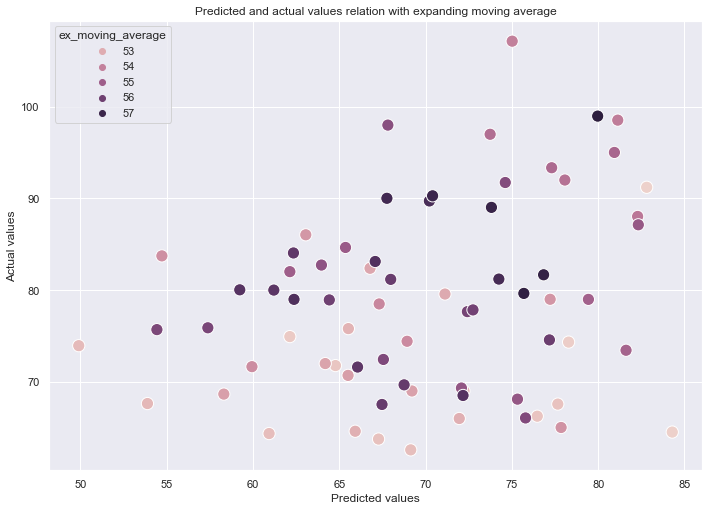

In [49]:
sns.scatterplot(x=y_hat, y=y_test, hue='ex_moving_average', data=data_test, s=150)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Predicted and actual values relation with expanding moving average')
plt.savefig('Plots/2lasso_scatter.png', bbox_inches='tight')

## Elastic Model Non-Stationary Time Series

Accuracy on training set: 0.653
Accuracy on test set: -0.892
R2 is -0.8915744144678623
The mean absolute error is 11.638472896898483
The root mean squared error is 194.85684678071362
The mean absolute percentage error is 14.361180470707996


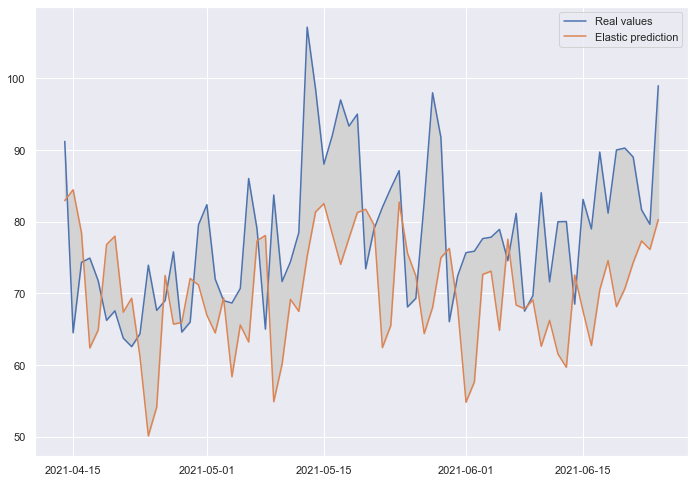

In [51]:
# Create the elastic model
from sklearn.linear_model import ElasticNet

enet = ElasticNet(alpha=0.001, l1_ratio=0.7, max_iter=5000000)
enet.fit(X_train, y_train)
y_hat = enet.predict(X_test)

# Pint all the scores:
print("Accuracy on training set: {:.3f}".format(enet.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(enet.score(X_test, y_test)))
# Scores:
# R^2
print('R2 is {}'
      .format(metrics.r2_score(y_test, y_hat)))
# MAE
print('The mean absolute error is {}'
      .format(metrics.mean_absolute_error(y_test, y_hat)))
# RMSE
print('The root mean squared error is {}'
      .format(metrics.mean_squared_error(y_test, y_hat)))
#MAPE
print('The mean absolute percentage error is {}'
      .format(mean_absolute_percentage_error(y_test, y_hat)))

plt.plot(data_test.index,  y_test, label='Real values')
plt.plot(data_test.index, y_hat, label='Elastic prediction')
plt.legend()
plt.fill_between(data_test.index, y_test, y_hat, color='lightgrey')
plt.savefig('Plots/2rf_elast_plot.png', bbox_inches='tight')
plt.show()

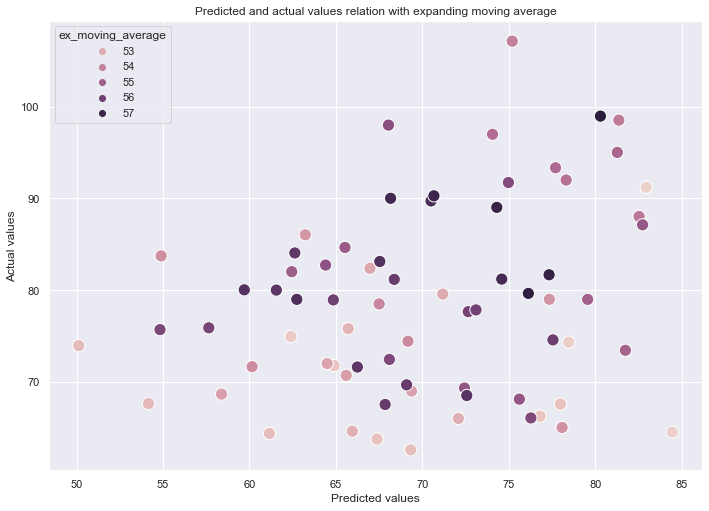

In [52]:
sns.scatterplot(x=y_hat, y=y_test, hue='ex_moving_average', data=data_test, s=150)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Predicted and actual values relation with expanding moving average')
plt.savefig('Plots/2elast_scatter.png', bbox_inches='tight')

# Applying models to Stationary Time Series

#### Redefining all the data

In [53]:
# New dataframe with differenciated features and value, change all the old columns for new ones
diff_data = data.copy()
for i in range(1,14):
    add_lag_feature(i, 'diff_value', diff_data)
    
# Need to be better to not include diff_value itself
add_standard_moving_average(15,'1_day_lag',diff_data)
add_standard_moving_average(7,'1_day_lag',diff_data)
add_standard_moving_average(3,'1_day_lag',diff_data)
add_standard_moving_average(2,'1_day_lag',diff_data)
add_expanding_moving_average('1_day_lag',diff_data)

# Dividing the dataframe into test and trining sets.
head, tail = divide_time_df(diff_data, 0.8)
data_train = diff_data.head(int(head))
data_test = diff_data.tail(int(tail))
data_train.index = pd.DatetimeIndex(data_train.index.values,
                               freq=data_train.index.inferred_freq)

# Original data train/test
original_data_train = data.head(int(head))
original_data_test = data.tail(int(tail))

# Converting the dataframes to arrays for sklearn
X_train = data_train.drop(['diff_value','value','start_time_uk','month_name','weekday_name'], axis=1).values
y_train = data_train.diff_value.values
X_test = data_test.drop(['diff_value','value','start_time_uk','month_name','weekday_name'], axis=1).values
y_test = data_test.diff_value.values

#Original data train/test
original_lag = original_data_test['1_day_lag'].values

features_names = diff_data.drop(['diff_value','value','start_time_uk','month_name','weekday_name'], axis=1).columns

Total days are 360
Head is 288.0
Tail is 72.0


## Random Forest Stationary Time Series

#### Grid search for best parameters (later improved to be tested in training)

In [54]:
# Array with all data
X = diff_data.drop(['value','diff_value','start_time_uk',
               'month_name','weekday_name'], axis=1).values
y = diff_data.value.values

In [55]:
def diff_expanding_window(n, test_size, X, y, n_estimators, min_samples_split, 
                               min_samples_leaf, max_depth, plot):
    """
    This functions evaluates a model with a expanding window method.
    """
    total_size = X.shape[0]
    score = []
    initial_train = total_size - test_size*n
    for i in range(1,n+1):
        X_train = X[:initial_train]
        X_test = X[initial_train:initial_train + test_size]
        y_train = y[:initial_train]
        y_test = y[initial_train:initial_train + test_size]
        original_lag = data.drop(['value','diff_value','start_time_uk',
               'month_name','weekday_name'], axis=1)['1_day_lag'].values[initial_train:initial_train + test_size]
        
        forest = RandomForestRegressor(n_estimators=n_estimators, min_samples_split= min_samples_split, 
                               min_samples_leaf=min_samples_leaf, max_depth=max_depth, random_state=0)
        forest.fit(X_train, y_train)
        y_hat = forest.predict(X_test)
        
        score.append(metrics.r2_score(y_test + original_lag,y_hat + original_lag))
        
        if plot == True:
            plt.plot(range(y_test.shape[0]), y_test, label='Real values')
            plt.plot(range(y_test.shape[0]), y_hat, label='RF prediction')
            plt.legend()
            plt.fill_between(range(y_test.shape[0]), y_test, y_hat, color='lightgrey')
            plt.show()
            print('R2 are {}'.format(score))
        
        initial_train = initial_train + test_size
        
    #print('R2 are {}'.format(score))    
    return(np.mean(score))

In [309]:
print("Size of training set: {} size of test set: {}".format(
          X_train.shape[0], X_test.shape[0]))

RF_best_score = -11
for n_estimators in [10, 20, 50,100]: 
    for max_depth in [5,7,9,10,15,50]:
        for min_samples_split in [2,3,4]:
            for min_samples_leaf in [1,2,3,4]:
                # for each combination of parameters, train a model
                # evaluate the forest on the test set
                score = diff_expanding_window(3, 30, X_train, y_train, n_estimators, 
                                         min_samples_split, min_samples_leaf, max_depth, False)
                # if we got a better score, store the score and parameters 
                if score > RF_best_score:
                    RF_best_score = score
                    RF_best_parameters = {'n_estimators': n_estimators, 'max_depth': max_depth,
                                         'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}
        
print("Best score: {:.2f}".format(RF_best_score)) 
print("Best parameters: {}".format(RF_best_parameters))

Size of training set: 288 size of test set: 72
Best score: -0.29
Best parameters: {'n_estimators': 20, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 2}


Accuracy on training set: 0.746
Accuracy on test set: 0.202
R2 is 0.20835887048212964
The mean absolute error is 6.942006897781924
The root mean squared error is 81.54936602014159
The mean absolute percentage error is 8.942518890839242


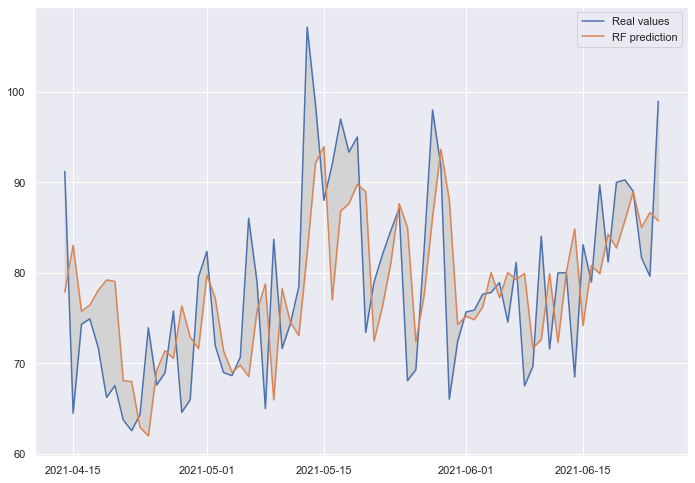

In [57]:
# Create the random forest model
forest = RandomForestRegressor(n_estimators=100, max_depth=9, min_samples_split=2, min_samples_leaf=2, random_state=0)
forest.fit(X_train, y_train)
y_hat = forest.predict(X_test)

# Pint all the scores:
print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))
# Scores:
# R^2
print('R2 is {}'
      .format(metrics.r2_score(y_test + original_lag,y_hat + original_lag)))
# MAE
print('The mean absolute error is {}'
      .format(metrics.mean_absolute_error(y_test + original_lag, y_hat + original_lag)))
# RMSE
print('The root mean squared error is {}'
      .format(metrics.mean_squared_error(y_test + original_lag, y_hat + original_lag)))
#MAPE
print('The mean absolute percentage error is {}'
      .format(mean_absolute_percentage_error(y_test + original_lag, y_hat + original_lag)))

#print(diff_expanding_window(5, 30, X, y, 100, min_samples_split, min_samples_leaf, 7, True))

plt.plot(data_test.index,  y_test + original_lag, label='Real values')
plt.plot(data_test.index, y_hat + original_lag, label='RF prediction')
plt.legend()
plt.fill_between(data_test.index, y_test + original_lag, y_hat + original_lag, color='lightgrey')
plt.savefig('Plots/2rf_stst_plot.png', bbox_inches='tight')
plt.show()

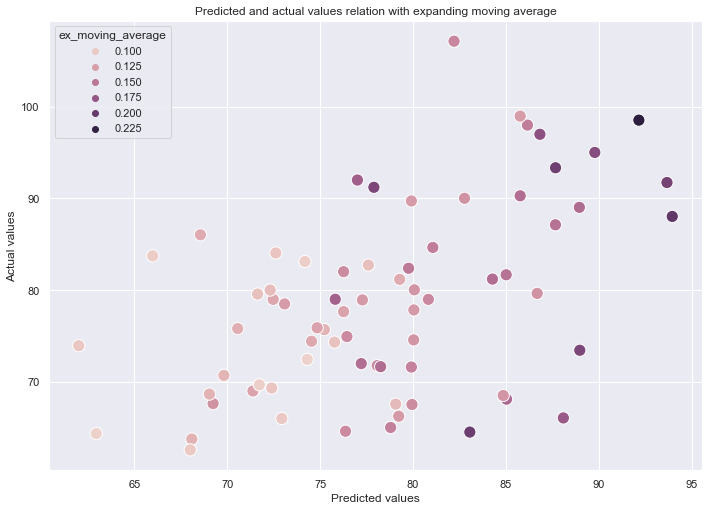

In [58]:
sns.scatterplot(x=y_hat+ original_lag, y=y_test+ original_lag, hue='ex_moving_average', data=data_test, s=150)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Predicted and actual values relation with expanding moving average')
plt.savefig('Plots/2rf_stst_scatter_ex.png', bbox_inches='tight')

#### Feature importance of the Differentiated Random Forest Model

Feature temperature , Score: 0.02091
Feature snow , Score: 0.00001
Feature ground_pressure , Score: 0.00592
Feature humidity , Score: 0.01585
Feature wind_speed , Score: 0.04459
Feature rain , Score: 0.00196
Feature pressure , Score: 0.00747
Feature wind_deg , Score: 0.02283
Feature clouds , Score: 0.00476
Feature weekday , Score: 0.01341
Feature month , Score: 0.00280
Feature year , Score: 0.00059
Feature weekday_or_weekend , Score: 0.00643
Feature 1_day_lag , Score: 0.21789
Feature 2_day_lag , Score: 0.01706
Feature 3_day_lag , Score: 0.00352
Feature 4_day_lag , Score: 0.01653
Feature 5_day_lag , Score: 0.00586
Feature 6_day_lag , Score: 0.01088
Feature 7_day_lag , Score: 0.05323
Feature 8_day_lag , Score: 0.00679
Feature 9_day_lag , Score: 0.03915
Feature 10_day_lag , Score: 0.00475
Feature 11_day_lag , Score: 0.00571
Feature 12_day_lag , Score: 0.00669
Feature 13_day_lag , Score: 0.00654
Feature 15_std_moving_average , Score: 0.03086
Feature 7_std_moving_average , Score: 0.14712
Fe

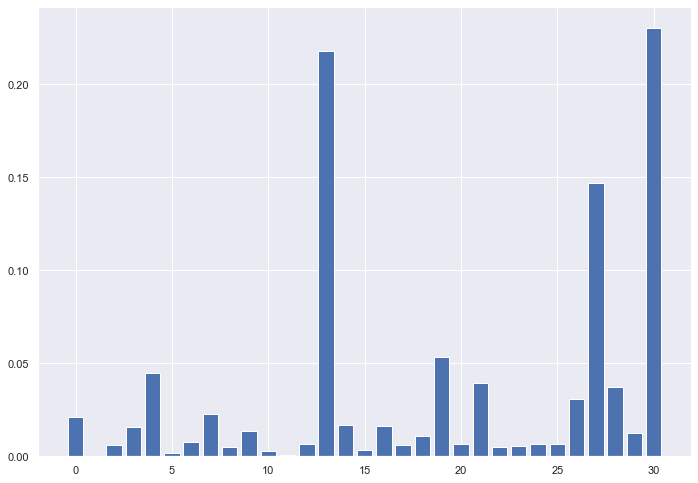

{'temperature': 0.02091157369177435, 'snow': 8.875307045740793e-06, 'ground_pressure': 0.0059200863237446385, 'humidity': 0.01585134501641477, 'wind_speed': 0.04458922552782222, 'rain': 0.001962017537051723, 'pressure': 0.0074690900079518235, 'wind_deg': 0.022825522118127894, 'clouds': 0.004756225021684536, 'weekday': 0.013405269896987489, 'month': 0.002797917383533343, 'year': 0.0005937105826849531, 'weekday_or_weekend': 0.0064290764739422185, '1_day_lag': 0.21789405618318736, '2_day_lag': 0.017064014092169295, '3_day_lag': 0.0035249520849647263, '4_day_lag': 0.01653461806531748, '5_day_lag': 0.005855993477922901, '6_day_lag': 0.010878434862398503, '7_day_lag': 0.053228700029170045, '8_day_lag': 0.006792003677481321, '9_day_lag': 0.03915127058075102, '10_day_lag': 0.004746209589024921, '11_day_lag': 0.005713744437286898, '12_day_lag': 0.006689957663319018, '13_day_lag': 0.006542612294453714, '15_std_moving_average': 0.030855872003216725, '7_std_moving_average': 0.14711524771018863, '3

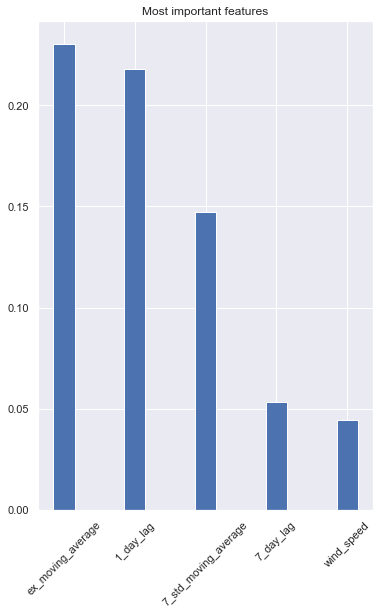

In [59]:
# Feature selection
importance = forest.feature_importances_
# summarize feature importance
features_dic={}
for i,v in enumerate(importance):
    print('Feature ' + features_names[i] + ' , Score: %.5f' % (v))
    features_dic[features_names[i]]= v
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()
print(features_dic)
five_keys = sorted(features_dic, key=features_dic.get, reverse=True)[:5]
print(five_keys)
most_used = {key: features_dic[key] for key in five_keys}
plt.figure(figsize=(6,9))
plt.bar(most_used.keys(), most_used.values(), width=0.3)
plt.xticks(rotation=45)
plt.title('Most important features')
plt.savefig('Plots/2cycle.png', bbox_inches='tight')

### Creating the PCA Random Forest model Stationary Time Series

Original shape: (360, 31)
Reduced shape: (360, 2)
X train shape: (288, 2)
X test shape: (72, 2)
y train shape: (288,)
y test shape: (72,)
Accuracy on training set: 0.623
Accuracy on test set: -7.744
R2 is -7.74392192919349
The mean absolute error is 27.915415195432796
The root mean squared error is 900.7380532257276
The mean absolute percentage error is 34.835035341727654


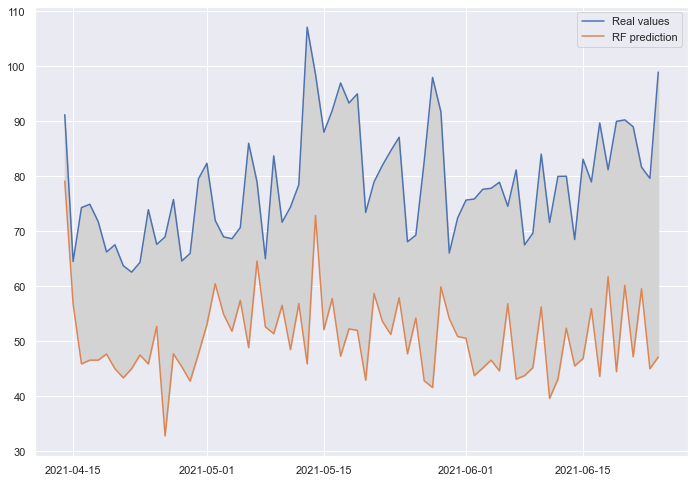

In [65]:
#We first scale the data
from sklearn.preprocessing import StandardScaler

X = diff_data.drop(['value', 'diff_value','start_time_uk','month_name','weekday_name'], axis=1).values
y = diff_data.value.values

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

#Reducing feature dimensionality with PCA
from sklearn.decomposition import PCA
#keep the first two principal components of the data 
pca = PCA(n_components=2)
pca.fit(X_scaled)
#transform data onto the first two principal components
X_pca = pca.transform(X_scaled)

print("Original shape: {}".format(str(X_scaled.shape))) 
print("Reduced shape: {}".format(str(X_pca.shape)))

X_train = X_pca[:int(head)]
X_test = X_pca[len(X_pca)-int(tail):len(X_pca)]
y_train = y[:int(head)]
y_test = y[len(X_pca)-int(tail):len(X_pca)]

print("X train shape: {}".format(X_train.shape)) 
print("X test shape: {}".format(X_test.shape))
print("y train shape: {}".format(y_train.shape)) 
print("y test shape: {}".format(y_test.shape))

forest = RandomForestRegressor(n_estimators=12, max_depth=7, random_state=0)
forest.fit(X_train, y_train)
y_hat = forest.predict(X_test)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

# Scores:
# R^2
print('R2 is {}'
      .format(metrics.r2_score(y_test,y_hat)))
# MAE
print('The mean absolute error is {}'
      .format(metrics.mean_absolute_error(y_test,y_hat)))
# RMSE
print('The root mean squared error is {}'
      .format(metrics.mean_squared_error(y_test,y_hat)))
#MAPE
print('The mean absolute percentage error is {}'
      .format(mean_absolute_percentage_error(y_test,y_hat)))

plt.plot(data_test.index, y_test, label='Real values')
plt.plot(data_test.index, y_hat, label='RF prediction')
plt.legend()
plt.fill_between(data_test.index, y_test, y_hat, color='lightgrey')
plt.savefig('Plots/2rfpca_stst_plot.png', bbox_inches='tight')

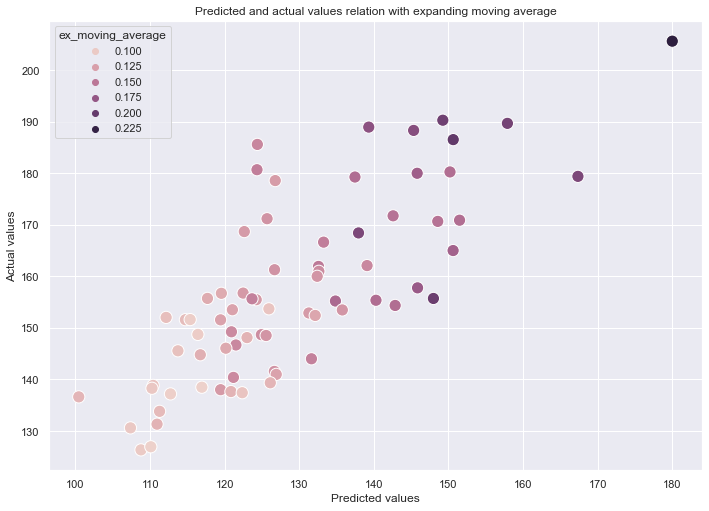

In [66]:
sns.scatterplot(x=y_hat+ original_lag, y=y_test+ original_lag, hue='ex_moving_average', data=data_test, s=150)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Predicted and actual values relation with expanding moving average')
plt.savefig('Plots/2rfpca_stst_scatter_ex.png', bbox_inches='tight')

### Lasso model Stationary Time Series

In [72]:
X_train = data_train.drop(['value','diff_value','start_time_uk','month_name','weekday_name'], axis=1).values
y_train = data_train.value.values

X_test = data_test.drop(['value','diff_value', 'start_time_uk','month_name','weekday_name'], axis=1).values
y_test = data_test.value.values

R2 is -3.952238174839203
The mean absolute error is 19.345384001743543
The root mean squared error is 510.14515097874744
The mean absolute percentage error is 23.677957995516202
Accuracy on training set: 0.603
Accuracy on test set: -3.952


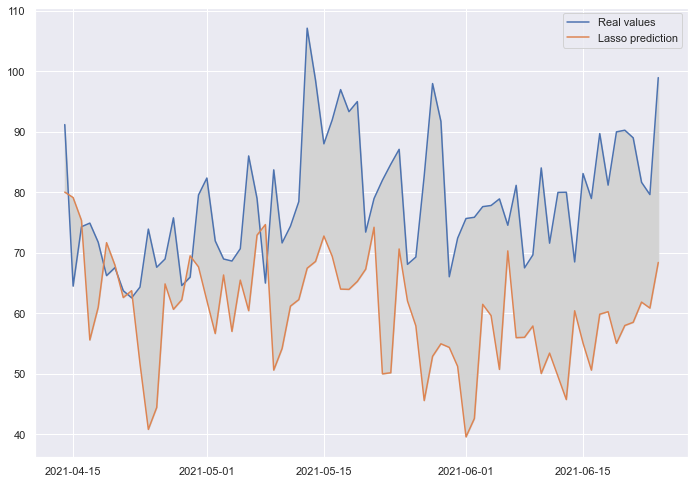

In [68]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.0001, max_iter=8000000)
lasso.fit(X_train, y_train)
y_hat = lasso.predict(X_test)

# Scores:
# R^2
print('R2 is {}'
      .format(metrics.r2_score(y_test,y_hat)))
# MAE
print('The mean absolute error is {}'
      .format(metrics.mean_absolute_error(y_test,y_hat)))
# RMSE
print('The root mean squared error is {}'
      .format(metrics.mean_squared_error(y_test,y_hat)))
#MAPE
print('The mean absolute percentage error is {}'
      .format(mean_absolute_percentage_error(y_test,y_hat)))

print("Accuracy on training set: {:.3f}".format(lasso.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(lasso.score(X_test, y_test)))

plt.plot(data_test.index, y_test, label='Real values')
plt.plot(data_test.index, y_hat, label='Lasso prediction')
plt.legend()
plt.fill_between(data_test.index, y_test, y_hat, color='lightgrey')
plt.savefig('Plots/2lasso_stst_plot.png', bbox_inches='tight')

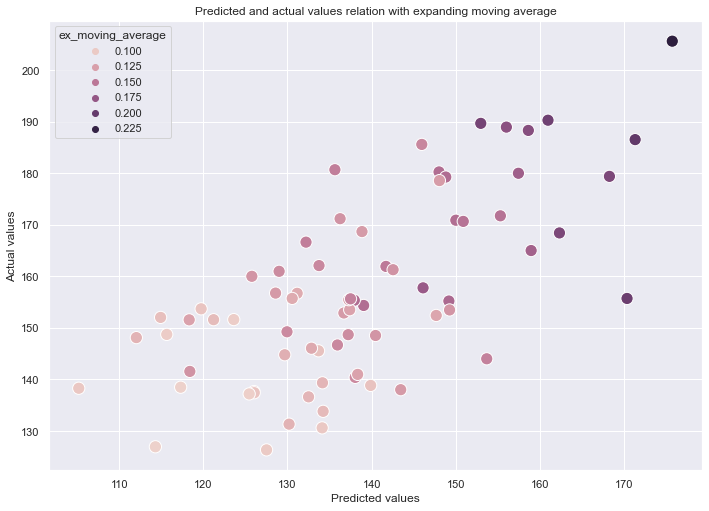

In [69]:
sns.scatterplot(x=y_hat+ original_lag, y=y_test+ original_lag, hue='ex_moving_average', data=data_test, s=150)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Predicted and actual values relation with expanding moving average')
plt.savefig('Plots/2lasso_stst_scatter_ex.png', bbox_inches='tight')

### Elastic Model Stationary Time Series

Accuracy on training set: 0.599
Accuracy on test set: -3.739
R2 is -0.6227341608600598
The mean absolute error is 18.867158823645546
The root mean squared error is 488.1732201124462
The mean absolute percentage error is 11.713879723974891


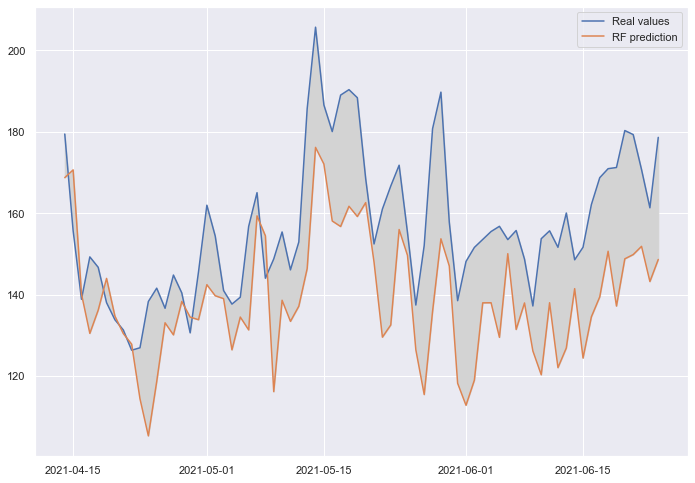

In [70]:
# Create the elastic model
from sklearn.linear_model import ElasticNet

enet = ElasticNet(alpha=0.001, l1_ratio=0.8, max_iter=8000000)
enet.fit(X_train, y_train)
y_hat = enet.predict(X_test)

# Pint all the scores:
print("Accuracy on training set: {:.3f}".format(enet.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(enet.score(X_test, y_test)))
# Scores:
# R^2
print('R2 is {}'
      .format(metrics.r2_score(y_test + original_lag,y_hat + original_lag)))
# MAE
print('The mean absolute error is {}'
      .format(metrics.mean_absolute_error(y_test + original_lag, y_hat + original_lag)))
# RMSE
print('The root mean squared error is {}'
      .format(metrics.mean_squared_error(y_test + original_lag, y_hat + original_lag)))
#MAPE
print('The mean absolute percentage error is {}'
      .format(mean_absolute_percentage_error(y_test + original_lag, y_hat + original_lag)))

plt.plot(data_test.index,  y_test + original_lag, label='Real values')
plt.plot(data_test.index, y_hat + original_lag, label='RF prediction')
plt.legend()
plt.fill_between(data_test.index, y_test + original_lag, y_hat + original_lag, color='lightgrey')
plt.savefig('Plots/2elastic_stst_plot.png', bbox_inches='tight')
plt.show()

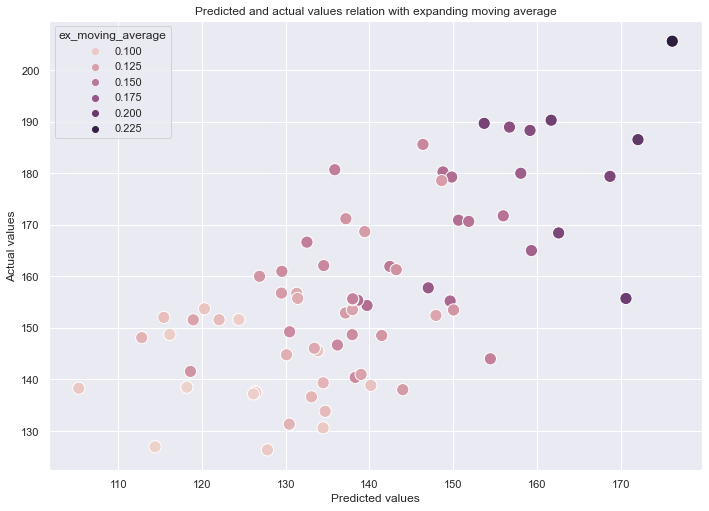

In [71]:
sns.scatterplot(x=y_hat+ original_lag, y=y_test+ original_lag, hue='ex_moving_average', data=data_test, s=150)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Predicted and actual values relation with expanding moving average')
plt.savefig('Plots/2elastic_stst_scatter_ex.png', bbox_inches='tight')